## Context:

* problem: optimization problem

* Should: Timing for charging and discharging i guess

* Objective: When to charge and discharge
* Constraints: - Physical and Commercial market attributes
* Decision Variables: Levers


## Battery Storage Information:

* Power Capacity (kW or MW) is the total possible instantaneous charge/discharge capability of the BESS
* Energy Capacity (kWh or MWh) is the maximum amount of stored energy in the BESS
* Storage Duration (h) is the number of hours BESS will take to discharge at its power capacity before depleting its energy capacity or vice versa
* State of Charge, SOC (%) represents the battery’s present level of charge and ranges from completely discharged (0%) to fully charged (100%)
* Charging efficiency (%) is the energy charged to the battery divided by the energy consumed from the grid
* Discharging efficiency (%) is the energy supplied to the grid divided by the energy discharged by the battery


## TBN:

sum of the top n priced hours in a day  subtract the sum of the bottom n priced hours in a day === the revenue you could generate from a BESS project with n hours of duration.

Limitations:

The TBn method does not ensure State of Charge (SOC) feasibility.
There may be instances where one of the T2 hours occurs when the battery has no energy, or B2 hours occur when the battery is at full charge.

In [2]:
## importing the libraries:

import pandas as pd
import numpy as np

In [3]:
## since the excel file has multiple sheets:
rtm_prices_excel = pd.read_excel("https://github.com/aps0611/case_energy/raw/main/RTM_Prices_2022.xlsx", sheet_name = None)
dam_prices_excel = pd.read_excel("https://github.com/aps0611/case_energy/raw/main/DAM_Prices_2022.xlsx", sheet_name = None)

In [4]:
## combining all the sheets into single dataframe

rtm_prices = pd.concat(rtm_prices_excel.values(), ignore_index=True)
dam_prices = pd.concat(dam_prices_excel.values(), ignore_index=True)

Lets explore the data:

In [5]:
rtm_prices.head(5)

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point,Settlement Point Price
0,01/01/2022,1,1,N,HB_BUSAVG,52.77
1,01/01/2022,1,2,N,HB_BUSAVG,120.80
2,01/01/2022,1,3,N,HB_BUSAVG,41.02
3,01/01/2022,1,4,N,HB_BUSAVG,35.00
4,01/01/2022,1,1,N,HB_HOUSTON,52.82


In [6]:
rtm_prices.shape

(805920, 6)

In [7]:
rtm_prices.describe(include="all")

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point,Settlement Point Price
count,805920,805920.000000,805920.000000,805920,805920,805920.000000
unique,365,NaN,NaN,2,15,NaN
top,11/06/2022,NaN,NaN,N,LZ_AEN,NaN
freq,2300,NaN,NaN,805828,70080,NaN
mean,NaN,12.499886,2.500000,NaN,NaN,63.250648
std,NaN,6.922356,1.118035,NaN,NaN,180.135303
min,NaN,1.000000,1.000000,NaN,NaN,-251.000000
25%,NaN,6.750000,1.750000,NaN,NaN,27.950000
50%,NaN,12.500000,2.500000,NaN,NaN,44.630000
75%,NaN,18.250000,3.250000,NaN,NaN,66.580000


In [8]:
## Delivery hour:

'''
min = 1    ---------------    00.00 midnight- assume
max = 24   ---------------    23.00 assume

'''

'\nmin = 1    ---------------    00.00 midnight- assume\nmax = 24   ---------------    23.00 assume\n\n'

In [9]:
rtm_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805920 entries, 0 to 805919
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Delivery Date           805920 non-null  object 
 1   Delivery Hour           805920 non-null  int64  
 2   Delivery Interval       805920 non-null  int64  
 3   Repeated Hour Flag      805920 non-null  object 
 4   Settlement Point        805920 non-null  object 
 5   Settlement Point Price  805920 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 36.9+ MB


In [10]:
def time_modification(delivery_hour):
    return f'{delivery_hour - 1:02d}'

In [11]:
time_modification(24)

'23'

In [12]:
rtm_prices['Delivery_Hour_new'] = rtm_prices['Delivery Hour'].apply(time_modification)

In [13]:
rtm_prices['Delivery_interval_new'] = (rtm_prices['Delivery Interval'] - 1) * 15

In [14]:
rtm_prices['dateTime'] = pd.to_datetime(rtm_prices['Delivery Date'] + ' ' + rtm_prices['Delivery_Hour_new'] + ':00:00') + pd.to_timedelta(rtm_prices['Delivery_interval_new'], unit='minutes')

In [15]:
rtm_prices.head(5)

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point,Settlement Point Price,Delivery_Hour_new,Delivery_interval_new,dateTime
0,01/01/2022,1,1,N,HB_BUSAVG,52.77,00,0,2022-01-01 00:00:00
1,01/01/2022,1,2,N,HB_BUSAVG,120.80,00,15,2022-01-01 00:15:00
2,01/01/2022,1,3,N,HB_BUSAVG,41.02,00,30,2022-01-01 00:30:00
3,01/01/2022,1,4,N,HB_BUSAVG,35.00,00,45,2022-01-01 00:45:00
4,01/01/2022,1,1,N,HB_HOUSTON,52.82,00,0,2022-01-01 00:00:00


In [16]:
rtm_prices.dateTime.dtype

dtype('<M8[ns]')

In [17]:
dam_prices.head(5)

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point,Settlement Point Price
0,01/01/2022,1,N,HB_BUSAVG,32.72
1,01/01/2022,1,N,HB_HOUSTON,33.20
2,01/01/2022,1,N,HB_HUBAVG,32.69
3,01/01/2022,1,N,HB_NORTH,33.41
4,01/01/2022,1,N,HB_PAN,31.28


In [18]:
dam_prices.shape

(131400, 5)

In [19]:
dam_prices.describe()

,Delivery Hour,Settlement Point Price
count,131400.000000,131400.000000
mean,12.499886,64.795283
std,6.922378,91.103672
min,1.000000,-20.930000
25%,6.750000,33.890000
50%,12.500000,48.400000
75%,18.250000,69.612500
max,24.000000,3051.130000


In [20]:
dam_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131400 entries, 0 to 131399
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Delivery Date           131400 non-null  object 
 1   Delivery Hour           131400 non-null  int64  
 2   Repeated Hour Flag      131400 non-null  object 
 3   Settlement Point        131400 non-null  object 
 4   Settlement Point Price  131400 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 5.0+ MB


NOTE: the delivery date is in object type

In [21]:
## Delivery hour:

'''
min = 1    ---------------    00.00 midnight- assume
max = 24   ---------------    23.00 assume

'''

'\nmin = 1    ---------------    00.00 midnight- assume\nmax = 24   ---------------    23.00 assume\n\n'

In [22]:
dam_prices.head(5)

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point,Settlement Point Price
0,01/01/2022,1,N,HB_BUSAVG,32.72
1,01/01/2022,1,N,HB_HOUSTON,33.20
2,01/01/2022,1,N,HB_HUBAVG,32.69
3,01/01/2022,1,N,HB_NORTH,33.41
4,01/01/2022,1,N,HB_PAN,31.28


In [23]:
## combine the delivery date and hour:

dam_prices['Delivery_Hour_new'] = dam_prices['Delivery Hour'].apply(time_modification)
dam_prices['dateTime'] = pd.to_datetime(dam_prices['Delivery Date'] + ' ' + dam_prices['Delivery_Hour_new'].astype(str) + ':00:00')
dam_prices['dateTime'] = dam_prices['dateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [24]:
dam_prices.head(5)

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point,Settlement Point Price,Delivery_Hour_new,dateTime
0,01/01/2022,1,N,HB_BUSAVG,32.72,00,2022-01-01 00:00:00
1,01/01/2022,1,N,HB_HOUSTON,33.20,00,2022-01-01 00:00:00
2,01/01/2022,1,N,HB_HUBAVG,32.69,00,2022-01-01 00:00:00
3,01/01/2022,1,N,HB_NORTH,33.41,00,2022-01-01 00:00:00
4,01/01/2022,1,N,HB_PAN,31.28,00,2022-01-01 00:00:00


# 1. Create a csv file containing DAM & RTM prices at hourly intervals from Jan 1 to Dec 31, 2022 for HB_NORTH

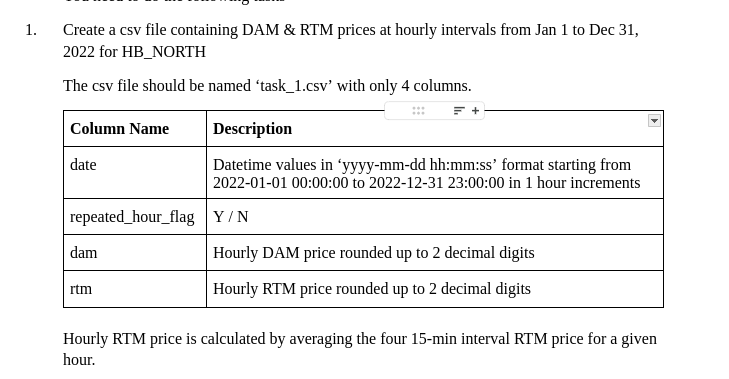

In [25]:
dam_prices_HB_NORTH = dam_prices[dam_prices['Settlement Point'] == 'HB_NORTH']
dam_prices_HB_NORTH.head(3)

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point,Settlement Point Price,Delivery_Hour_new,dateTime
3,01/01/2022,1,N,HB_NORTH,33.41,00,2022-01-01 00:00:00
18,01/01/2022,2,N,HB_NORTH,25.22,01,2022-01-01 01:00:00
33,01/01/2022,3,N,HB_NORTH,22.91,02,2022-01-01 02:00:00


In [26]:
rtm_prices_HB_NORTH = rtm_prices[rtm_prices['Settlement Point'] == 'HB_NORTH']
rtm_prices_HB_NORTH.head(3)

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point,Settlement Point Price,Delivery_Hour_new,Delivery_interval_new,dateTime
12,01/01/2022,1,1,N,HB_NORTH,53.94,00,0,2022-01-01 00:00:00
13,01/01/2022,1,2,N,HB_NORTH,125.73,00,15,2022-01-01 00:15:00
14,01/01/2022,1,3,N,HB_NORTH,42.02,00,30,2022-01-01 00:30:00


In [27]:
dam_prices_HB_NORTH.shape, rtm_prices_HB_NORTH.shape

((8760, 7), (35040, 9))

In [28]:
## Hourly RTM price is calculated by averaging the four 15-min interval RTM price for a given hour.

rtm_prices_HB_NORTH['hourly_rtm_price'] = rtm_prices_HB_NORTH.groupby(['Delivery Date', 'Delivery Hour'])['Settlement Point Price'].transform('mean')

<ipython-input-28-ceb30eef3ea9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtm_prices_HB_NORTH['hourly_rtm_price'] = rtm_prices_HB_NORTH.groupby(['Delivery Date', 'Delivery Hour'])['Settlement Point Price'].transform('mean')


In [29]:
rtm_prices_HB_NORTH.Delivery_interval_new.dtype

dtype('int64')

In [30]:
rtm_prices_HB_NORTH.Delivery_interval_new.value_counts()

0     8760
15    8760
30    8760
45    8760
Name: Delivery_interval_new, dtype: int64

In [31]:
rtm_prices_HB_NORTH_filtered = rtm_prices_HB_NORTH[~rtm_prices_HB_NORTH['Delivery_interval_new'].isin([15, 30, 45])]
rtm_prices_HB_NORTH_filtered.head(5)

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point,Settlement Point Price,Delivery_Hour_new,Delivery_interval_new,dateTime,hourly_rtm_price
12,01/01/2022,1,1,N,HB_NORTH,53.94,00,0,2022-01-01 00:00:00,64.3600
104,01/01/2022,2,1,N,HB_NORTH,32.87,01,0,2022-01-01 01:00:00,32.4475
196,01/01/2022,3,1,N,HB_NORTH,29.91,02,0,2022-01-01 02:00:00,25.5400
288,01/01/2022,4,1,N,HB_NORTH,23.39,03,0,2022-01-01 03:00:00,22.4175
380,01/01/2022,5,1,N,HB_NORTH,8.58,04,0,2022-01-01 04:00:00,15.9475


In [32]:
rtm_prices_HB_NORTH_filtered.shape

(8760, 10)

In [33]:
dam_prices_HB_NORTH.shape

(8760, 7)

In [34]:
## merged_df = pd.merge(rtm_prices_HB_NORTH_filtered, dam_prices_HB_NORTH, on='dateTime', how='inner')

In [35]:
rtm_prices_HB_NORTH_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 12 to 805840
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Delivery Date           8760 non-null   object        
 1   Delivery Hour           8760 non-null   int64         
 2   Delivery Interval       8760 non-null   int64         
 3   Repeated Hour Flag      8760 non-null   object        
 4   Settlement Point        8760 non-null   object        
 5   Settlement Point Price  8760 non-null   float64       
 6   Delivery_Hour_new       8760 non-null   object        
 7   Delivery_interval_new   8760 non-null   int64         
 8   dateTime                8760 non-null   datetime64[ns]
 9   hourly_rtm_price        8760 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 752.8+ KB


In [36]:
dam_prices_HB_NORTH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 3 to 131388
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Delivery Date           8760 non-null   object 
 1   Delivery Hour           8760 non-null   int64  
 2   Repeated Hour Flag      8760 non-null   object 
 3   Settlement Point        8760 non-null   object 
 4   Settlement Point Price  8760 non-null   float64
 5   Delivery_Hour_new       8760 non-null   object 
 6   dateTime                8760 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 547.5+ KB


In [37]:
dam_prices_HB_NORTH['dateTime'] = pd.to_datetime(dam_prices_HB_NORTH['dateTime'])

<ipython-input-37-83744e6cc759>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dam_prices_HB_NORTH['dateTime'] = pd.to_datetime(dam_prices_HB_NORTH['dateTime'])


In [38]:
dam_prices_HB_NORTH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 3 to 131388
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Delivery Date           8760 non-null   object        
 1   Delivery Hour           8760 non-null   int64         
 2   Repeated Hour Flag      8760 non-null   object        
 3   Settlement Point        8760 non-null   object        
 4   Settlement Point Price  8760 non-null   float64       
 5   Delivery_Hour_new       8760 non-null   object        
 6   dateTime                8760 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 547.5+ KB


In [39]:
merged_df = pd.merge(rtm_prices_HB_NORTH_filtered, dam_prices_HB_NORTH, on='dateTime', how='inner')

In [40]:
merged_df.shape

(8762, 16)

In [41]:
task1 = merged_df[['dateTime', 'Repeated Hour Flag_y','Settlement Point Price_y','hourly_rtm_price']]
task1.head(5)

,dateTime,Repeated Hour Flag_y,Settlement Point Price_y,hourly_rtm_price
0,2022-01-01 00:00:00,N,33.41,64.3600
1,2022-01-01 01:00:00,N,25.22,32.4475
2,2022-01-01 02:00:00,N,22.91,25.5400
3,2022-01-01 03:00:00,N,18.41,22.4175
4,2022-01-01 04:00:00,N,12.19,15.9475


In [42]:
task1.columns

Index(['dateTime', 'Repeated Hour Flag_y', 'Settlement Point Price_y',
       'hourly_rtm_price'],
      dtype='object')

In [43]:
task1.rename(columns={
    'dateTime': 'date',
    'Repeated Hour Flag_y': 'repeated_hour_flag',
    'Settlement Point Price_y': 'dam',
    'hourly_rtm_price': 'rtm'
}, inplace=True)

<ipython-input-43-4ea5c164f901>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task1.rename(columns={


In [44]:
task1.head(5)

,date,repeated_hour_flag,dam,rtm
0,2022-01-01 00:00:00,N,33.41,64.3600
1,2022-01-01 01:00:00,N,25.22,32.4475
2,2022-01-01 02:00:00,N,22.91,25.5400
3,2022-01-01 03:00:00,N,18.41,22.4175
4,2022-01-01 04:00:00,N,12.19,15.9475


In [45]:
task1.to_csv('task1.csv')

In [46]:
task1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8762 entries, 0 to 8761
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                8762 non-null   datetime64[ns]
 1   repeated_hour_flag  8762 non-null   object        
 2   dam                 8762 non-null   float64       
 3   rtm                 8762 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 342.3+ KB


In [47]:
task1.describe(include= "all")

<ipython-input-47-3b6c7f5281ce>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  task1.describe(include= "all")


,date,repeated_hour_flag,dam,rtm
count,8762,8762,8762.000000,8762.000000
unique,8759,2,NaN,NaN
top,2022-11-06 01:00:00,N,NaN,NaN
freq,4,8760,NaN,NaN
first,2022-01-01 00:00:00,NaN,NaN,NaN
last,2022-12-31 23:00:00,NaN,NaN,NaN
mean,NaN,NaN,64.596864,62.143976
std,NaN,NaN,89.535656,170.225858
min,NaN,NaN,2.370000,-228.740000
25%,NaN,NaN,34.622500,28.221250


# 2. Create a csv file containing DAM & RTM prices at 15-min intervals from Jan 1 to Dec 31, 2022 for HB_NORTH

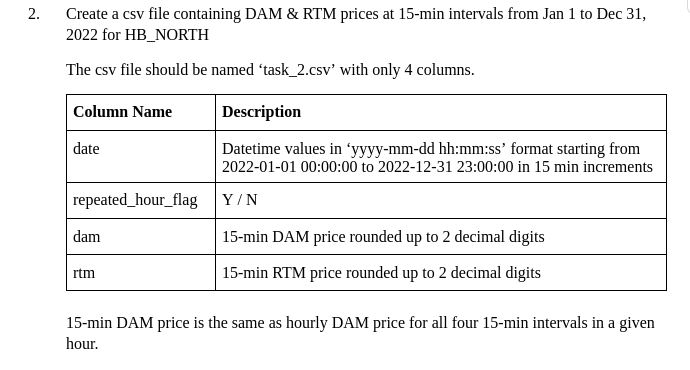

In [48]:
rtm_prices['Delivery Date'].value_counts()

11/06/2022    2300
01/01/2022    2208
08/29/2022    2208
09/06/2022    2208
09/05/2022    2208
              ... 
04/30/2022    2208
04/29/2022    2208
04/28/2022    2208
12/31/2022    2208
03/13/2022    2116
Name: Delivery Date, Length: 365, dtype: int64

December 31 2022 ?? There is no data- assuming one month data only

In [49]:
rtm_prices_HB_NORTH_filtered.head(5)

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point,Settlement Point Price,Delivery_Hour_new,Delivery_interval_new,dateTime,hourly_rtm_price
12,01/01/2022,1,1,N,HB_NORTH,53.94,00,0,2022-01-01 00:00:00,64.3600
104,01/01/2022,2,1,N,HB_NORTH,32.87,01,0,2022-01-01 01:00:00,32.4475
196,01/01/2022,3,1,N,HB_NORTH,29.91,02,0,2022-01-01 02:00:00,25.5400
288,01/01/2022,4,1,N,HB_NORTH,23.39,03,0,2022-01-01 03:00:00,22.4175
380,01/01/2022,5,1,N,HB_NORTH,8.58,04,0,2022-01-01 04:00:00,15.9475


In [50]:
dam_prices_HB_NORTH.head(5)

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point,Settlement Point Price,Delivery_Hour_new,dateTime
3,01/01/2022,1,N,HB_NORTH,33.41,00,2022-01-01 00:00:00
18,01/01/2022,2,N,HB_NORTH,25.22,01,2022-01-01 01:00:00
33,01/01/2022,3,N,HB_NORTH,22.91,02,2022-01-01 02:00:00
48,01/01/2022,4,N,HB_NORTH,18.41,03,2022-01-01 03:00:00
63,01/01/2022,5,N,HB_NORTH,12.19,04,2022-01-01 04:00:00


In [51]:
# ## create duplicate rows:
# dam_prices_hb_north_15min = dam_prices_HB_NORTH.loc[dam_prices_HB_NORTH.index.repeat(4)].reset_index(drop=True)
# dam_prices_hb_north_15min

In [52]:
merged_df_task2 = pd.merge(rtm_prices_HB_NORTH, dam_prices_HB_NORTH, on='dateTime', how='outer')
merged_df_task2.head(5)

,Delivery Date_x,Delivery Hour_x,Delivery Interval,Repeated Hour Flag_x,Settlement Point_x,Settlement Point Price_x,Delivery_Hour_new_x,Delivery_interval_new,dateTime,hourly_rtm_price,Delivery Date_y,Delivery Hour_y,Repeated Hour Flag_y,Settlement Point_y,Settlement Point Price_y,Delivery_Hour_new_y
0,01/01/2022,1,1,N,HB_NORTH,53.94,00,0,2022-01-01 00:00:00,64.3600,01/01/2022,1.0,N,HB_NORTH,33.41,00
1,01/01/2022,1,2,N,HB_NORTH,125.73,00,15,2022-01-01 00:15:00,64.3600,NaN,NaN,NaN,NaN,NaN,NaN
2,01/01/2022,1,3,N,HB_NORTH,42.02,00,30,2022-01-01 00:30:00,64.3600,NaN,NaN,NaN,NaN,NaN,NaN
3,01/01/2022,1,4,N,HB_NORTH,35.75,00,45,2022-01-01 00:45:00,64.3600,NaN,NaN,NaN,NaN,NaN,NaN
4,01/01/2022,2,1,N,HB_NORTH,32.87,01,0,2022-01-01 01:00:00,32.4475,01/01/2022,2.0,N,HB_NORTH,25.22,01


In [53]:
merged_df_task2['Settlement Point Price_y'].fillna(method='ffill', inplace=True)

In [54]:
merged_df_task2.head(5)

,Delivery Date_x,Delivery Hour_x,Delivery Interval,Repeated Hour Flag_x,Settlement Point_x,Settlement Point Price_x,Delivery_Hour_new_x,Delivery_interval_new,dateTime,hourly_rtm_price,Delivery Date_y,Delivery Hour_y,Repeated Hour Flag_y,Settlement Point_y,Settlement Point Price_y,Delivery_Hour_new_y
0,01/01/2022,1,1,N,HB_NORTH,53.94,00,0,2022-01-01 00:00:00,64.3600,01/01/2022,1.0,N,HB_NORTH,33.41,00
1,01/01/2022,1,2,N,HB_NORTH,125.73,00,15,2022-01-01 00:15:00,64.3600,NaN,NaN,NaN,NaN,33.41,NaN
2,01/01/2022,1,3,N,HB_NORTH,42.02,00,30,2022-01-01 00:30:00,64.3600,NaN,NaN,NaN,NaN,33.41,NaN
3,01/01/2022,1,4,N,HB_NORTH,35.75,00,45,2022-01-01 00:45:00,64.3600,NaN,NaN,NaN,NaN,33.41,NaN
4,01/01/2022,2,1,N,HB_NORTH,32.87,01,0,2022-01-01 01:00:00,32.4475,01/01/2022,2.0,N,HB_NORTH,25.22,01


In [55]:
merged_df_task2.columns

Index(['Delivery Date_x', 'Delivery Hour_x', 'Delivery Interval',
       'Repeated Hour Flag_x', 'Settlement Point_x',
       'Settlement Point Price_x', 'Delivery_Hour_new_x',
       'Delivery_interval_new', 'dateTime', 'hourly_rtm_price',
       'Delivery Date_y', 'Delivery Hour_y', 'Repeated Hour Flag_y',
       'Settlement Point_y', 'Settlement Point Price_y',
       'Delivery_Hour_new_y'],
      dtype='object')

In [56]:
task2_df = merged_df_task2[['dateTime', 'Repeated Hour Flag_x','Settlement Point Price_y','Settlement Point Price_x']]

In [57]:
task2_df.columns

Index(['dateTime', 'Repeated Hour Flag_x', 'Settlement Point Price_y',
       'Settlement Point Price_x'],
      dtype='object')

In [58]:
task2_df.rename(columns={
    'dateTime': 'date',
    'Repeated Hour Flag_x': 'repeated_hour_flag',
    'Settlement Point Price_y': 'dam',
    'Settlement Point Price_x': 'rtm'
}, inplace=True)

<ipython-input-58-df38a7aa31e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task2_df.rename(columns={


In [59]:
task2_df.head(5)

,date,repeated_hour_flag,dam,rtm
0,2022-01-01 00:00:00,N,33.41,53.94
1,2022-01-01 00:15:00,N,33.41,125.73
2,2022-01-01 00:30:00,N,33.41,42.02
3,2022-01-01 00:45:00,N,33.41,35.75
4,2022-01-01 01:00:00,N,25.22,32.87


In [60]:
task2_df.describe(include='all')

<ipython-input-60-43991ba9ba87>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  task2_df.describe(include='all')


,date,repeated_hour_flag,dam,rtm
count,35042,35042,35042.000000,35042.000000
unique,35036,2,NaN,NaN
top,2022-11-06 01:00:00,N,NaN,NaN
freq,4,35037,NaN,NaN
first,2022-01-01 00:00:00,NaN,NaN,NaN
last,2022-12-31 23:45:00,NaN,NaN,NaN
mean,NaN,NaN,64.606787,62.153327
std,NaN,NaN,89.536276,178.653389
min,NaN,NaN,2.370000,-251.000000
25%,NaN,NaN,34.630000,28.110000


In [61]:
task2_df.to_csv('task2.csv')

# 3. Calculate the daily TB2 revenue at HB_NORTH for the following scenarios using the csv files from task
###  Assume that the charge and discharge efficiency is 100%.


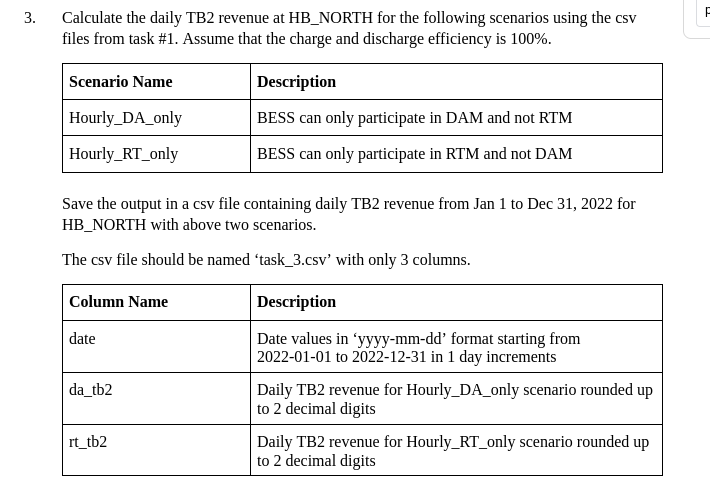

In [62]:
task1_df = task1
task1.head(5)

,date,repeated_hour_flag,dam,rtm
0,2022-01-01 00:00:00,N,33.41,64.3600
1,2022-01-01 01:00:00,N,25.22,32.4475
2,2022-01-01 02:00:00,N,22.91,25.5400
3,2022-01-01 03:00:00,N,18.41,22.4175
4,2022-01-01 04:00:00,N,12.19,15.9475


In [63]:
task1_df.head(3)

,date,repeated_hour_flag,dam,rtm
0,2022-01-01 00:00:00,N,33.41,64.3600
1,2022-01-01 01:00:00,N,25.22,32.4475
2,2022-01-01 02:00:00,N,22.91,25.5400


In [71]:
df3 = task1_df

In [72]:
df3[['date', 'time']] = df3['date'].astype(str).str.split(expand=True)

<ipython-input-72-2b2d2f840add>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[['date', 'time']] = df3['date'].astype(str).str.split(expand=True)
<ipython-input-72-2b2d2f840add>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[['date', 'time']] = df3['date'].astype(str).str.split(expand=True)


In [73]:
df3

,date,repeated_hour_flag,dam,rtm,time
0,2022-01-01,N,33.41,64.3600,00:00:00
1,2022-01-01,N,25.22,32.4475,01:00:00
2,2022-01-01,N,22.91,25.5400,02:00:00
3,2022-01-01,N,18.41,22.4175,03:00:00
4,2022-01-01,N,12.19,15.9475,04:00:00
...,...,...,...,...,...
8757,2022-12-31,N,16.04,9.2125,19:00:00
8758,2022-12-31,N,15.11,7.7625,20:00:00
8759,2022-12-31,N,14.37,2.4475,21:00:00
8760,2022-12-31,N,10.35,-1.6425,22:00:00


In [74]:
# Sort data by price in descending order
hourly_dam_only_sorted = df3.sort_values(by='dam', ascending=False)
hourly_rtm_only_sorted = df3.sort_values(by='rtm', ascending=False)

In [76]:
# Select top 2 and bottom 2 prices for each day for both scenarios
top_2_da_only = hourly_dam_only_sorted.groupby('date').head(2)
bottom_2_da_only = hourly_dam_only_sorted.groupby('date').tail(2)

top_2_rt_only = hourly_rtm_only_sorted.groupby('date').head(2)
bottom_2_rt_only = hourly_rtm_only_sorted.groupby('date').tail(2)

In [77]:
# Calculate daily TB2 revenue for both scenarios
daily_tb2_da_only = top_2_da_only.groupby('date')['dam'].sum() - bottom_2_da_only.groupby('date')['dam'].sum()

daily_tb2_rt_only = top_2_rt_only.groupby('date')['rtm'].sum() - bottom_2_rt_only.groupby('date')['rtm'].sum()

In [78]:
daily_tb2_da_only

date
2022-01-01     47.79
2022-01-02    136.30
2022-01-03    150.37
2022-01-04     50.67
2022-01-05     62.57
               ...  
2022-12-27    104.86
2022-12-28     43.37
2022-12-29     64.27
2022-12-30     55.32
2022-12-31     23.96
Name: dam, Length: 365, dtype: float64

In [80]:
daily_tb2_da_only = daily_tb2_da_only.round(2)
daily_tb2_rt_only = daily_tb2_rt_only.round(2)

In [83]:
daily_tb2_da_only.shape, daily_tb2_rt_only.shape

((365,), (365,))

In [118]:
task3_df = pd.DataFrame({'date': daily_tb2_da_only.index,
                           'da_tb2': daily_tb2_da_only.values,
                           'rt_tb2': daily_tb2_rt_only.values})

In [119]:
task3_df

,date,da_tb2,rt_tb2
0,2022-01-01,47.79,85.18
1,2022-01-02,136.30,61.40
2,2022-01-03,150.37,70.63
3,2022-01-04,50.67,48.06
4,2022-01-05,62.57,28.59
...,...,...,...
360,2022-12-27,104.86,113.89
361,2022-12-28,43.37,58.04
362,2022-12-29,64.27,88.41
363,2022-12-30,55.32,67.37


In [89]:
task3_df.to_csv('task3.csv')

# 4. Calculate the monthly TB2 revenue in $/kW-month units using the csv files from task for both scenarios at HB_NORTH.


Revenue ($/kW-month)
= Sum of daily revenue ($) / (Battery Power Capacity (kW) x Number of months)


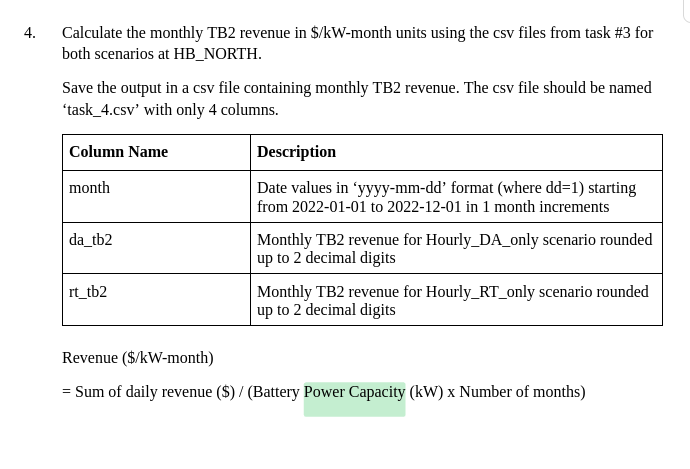

In [90]:
task3_df.head(3)

,date,da_tb2,rt_tb2
0,2022-01-01,47.79,85.18
1,2022-01-02,136.30,61.40
2,2022-01-03,150.37,70.63


In [91]:
## since we need to calculate the TB2 revenue on montly basis
task3_df['month'] = pd.to_datetime(task3_df['date']).dt.to_period('M')
task3_df

,date,da_tb2,rt_tb2,month
0,2022-01-01,47.79,85.18,2022-01
1,2022-01-02,136.30,61.40,2022-01
2,2022-01-03,150.37,70.63,2022-01
3,2022-01-04,50.67,48.06,2022-01
4,2022-01-05,62.57,28.59,2022-01
...,...,...,...,...
360,2022-12-27,104.86,113.89,2022-12
361,2022-12-28,43.37,58.04,2022-12
362,2022-12-29,64.27,88.41,2022-12
363,2022-12-30,55.32,67.37,2022-12


In [92]:
monthly_da_tb2 = task3_df.groupby('month')['da_tb2'].sum().reset_index()
monthly_rt_tb2 = task3_df.groupby('month')['rt_tb2'].sum().reset_index()

In [93]:
monthly_da_tb2, monthly_rt_tb2

(      month    da_tb2
 0   2022-01   2678.95
 1   2022-02   3697.41
 2   2022-03   4929.56
 3   2022-04   5427.42
 4   2022-05  10186.72
 5   2022-06   7006.83
 6   2022-07  21854.55
 7   2022-08   9078.50
 8   2022-09   4622.14
 9   2022-10   4228.47
 10  2022-11   3812.22
 11  2022-12   8152.23,
       month    rt_tb2
 0   2022-01   3185.30
 1   2022-02  10264.93
 2   2022-03   5489.99
 3   2022-04   7068.66
 4   2022-05  13748.56
 5   2022-06   3605.80
 6   2022-07  32840.36
 7   2022-08   8974.23
 8   2022-09   4063.84
 9   2022-10   6275.39
 10  2022-11   4147.13
 11  2022-12   9573.10)

In [94]:
battery_power_capacity_kw =  1000 # 1MW
monthly_da_tb2['da_tb2'] = monthly_da_tb2['da_tb2'] / (battery_power_capacity_kw * len(monthly_da_tb2))
monthly_rt_tb2['rt_tb2'] = monthly_rt_tb2['rt_tb2'] / (battery_power_capacity_kw * len(monthly_rt_tb2))

In [95]:
monthly_da_tb2

,month,da_tb2
0,2022-01,0.223246
1,2022-02,0.308117
2,2022-03,0.410797
3,2022-04,0.452285
4,2022-05,0.848893
5,2022-06,0.583902
6,2022-07,1.821212
7,2022-08,0.756542
8,2022-09,0.385178
9,2022-10,0.352373


In [96]:
monthly_rt_tb2

,month,rt_tb2
0,2022-01,0.265442
1,2022-02,0.855411
2,2022-03,0.457499
3,2022-04,0.589055
4,2022-05,1.145713
5,2022-06,0.300483
6,2022-07,2.736697
7,2022-08,0.747852
8,2022-09,0.338653
9,2022-10,0.522949


In [98]:
monthly_tb2_merged = pd.merge(monthly_rt_tb2, monthly_da_tb2, on='month')
monthly_tb2_merged

,month,rt_tb2,da_tb2
0,2022-01,0.265442,0.223246
1,2022-02,0.855411,0.308117
2,2022-03,0.457499,0.410797
3,2022-04,0.589055,0.452285
4,2022-05,1.145713,0.848893
5,2022-06,0.300483,0.583902
6,2022-07,2.736697,1.821212
7,2022-08,0.747852,0.756542
8,2022-09,0.338653,0.385178
9,2022-10,0.522949,0.352373


In [99]:
task4_df = monthly_tb2_merged
task4_df.to_csv('task4.csv')

# 5. Calculate the daily TB2 revenue at HB_NORTH using 15-min RTM prices from task Assume that the charge and discharge efficiency is 100%.

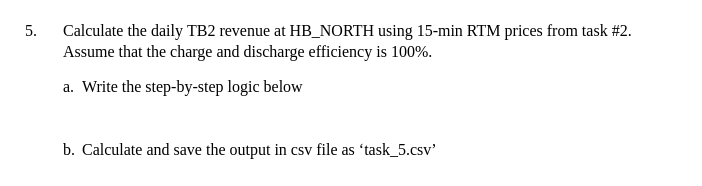

In [105]:
battery_power_capacity_kw = 1000  # 1 MW
battery_energy_capacity_kwh = 2000  # 2 MWh
charge_efficiency = 1.0  # 100%
discharge_efficiency = 1.0  # 100%

In [102]:
df5 = task2_df

In [103]:
df5[['date', 'time']] = df5['date'].astype(str).str.split(expand=True)

<ipython-input-103-35240cc6dc88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5[['date', 'time']] = df5['date'].astype(str).str.split(expand=True)
<ipython-input-103-35240cc6dc88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5[['date', 'time']] = df5['date'].astype(str).str.split(expand=True)


In [104]:
df5.head(5)

,date,repeated_hour_flag,dam,rtm,time
0,2022-01-01,N,33.41,53.94,00:00:00
1,2022-01-01,N,33.41,125.73,00:15:00
2,2022-01-01,N,33.41,42.02,00:30:00
3,2022-01-01,N,33.41,35.75,00:45:00
4,2022-01-01,N,25.22,32.87,01:00:00


In [106]:
# Sort data by price in descending order
interval_dam_only_sorted = df5.sort_values(by='dam', ascending=False)
interval_rtm_only_sorted = df5.sort_values(by='rtm', ascending=False)

In [112]:
# Select top 2 and bottom 2 prices for each day for both scenarios
interval_top_2_da_only = interval_dam_only_sorted.groupby('date').head(2)
interval_bottom_2_da_only = interval_dam_only_sorted.groupby('date').tail(2)

interval_top_2_rt_only = interval_rtm_only_sorted.groupby('date').head(2)
interval_bottom_2_rt_only = interval_rtm_only_sorted.groupby('date').tail(2)

In [113]:
# Calculate daily TB2 revenue for both scenarios
interval_daily_tb2_da_only = interval_top_2_da_only.groupby('date')['dam'].sum() - interval_bottom_2_da_only.groupby('date')['dam'].sum()

interval_daily_tb2_rt_only = interval_top_2_rt_only.groupby('date')['rtm'].sum() - interval_bottom_2_rt_only.groupby('date')['rtm'].sum()

In [115]:
interval_daily_tb2_da_only.shape, interval_daily_tb2_rt_only.shape

((365,), (365,))

In [117]:
task5_df = pd.DataFrame({'date': interval_daily_tb2_da_only.index,
                           'da_tb2': interval_daily_tb2_da_only.values,
                           'rt_tb2': interval_daily_tb2_rt_only.values})

In [120]:
task5_df.to_csv('task5.csv')

In [121]:
task5_df

,date,da_tb2,rt_tb2
0,2022-01-01,58.60,179.81
1,2022-01-02,150.52,81.78
2,2022-01-03,155.92,103.98
3,2022-01-04,51.86,76.20
4,2022-01-05,75.58,40.76
...,...,...,...
360,2022-12-27,107.08,129.21
361,2022-12-28,47.02,72.43
362,2022-12-29,71.50,111.76
363,2022-12-30,66.64,130.95


# 6 Calculate the daily TB2 revenue at HB_NORTH assuming charge and discharge efficiency of 95% for Hourly_DA_only scenario.


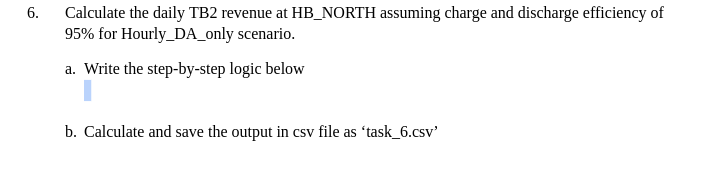

In [123]:
task3_df.head(5)

,date,da_tb2,rt_tb2
0,2022-01-01,47.79,85.18
1,2022-01-02,136.30,61.40
2,2022-01-03,150.37,70.63
3,2022-01-04,50.67,48.06
4,2022-01-05,62.57,28.59


In [124]:
## Hourly da only scenario i.e. for da_tb2 scenario

df6 = task3_df

In [125]:
df6['daily_tb2_revenue_0.95'] = df6['da_tb2'] * 0.95

In [126]:
df6.head(5)

,date,da_tb2,rt_tb2,daily_tb2_revenue_0.95
0,2022-01-01,47.79,85.18,45.4005
1,2022-01-02,136.30,61.40,129.4850
2,2022-01-03,150.37,70.63,142.8515
3,2022-01-04,50.67,48.06,48.1365
4,2022-01-05,62.57,28.59,59.4415


In [127]:
df6.to_csv('task6.csv')

# 7. Calculate the daily TB2 revenue at HBNORTH for Hourly DART best scenario

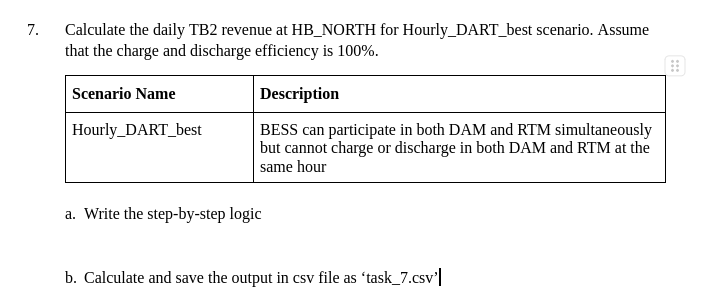

# 8.

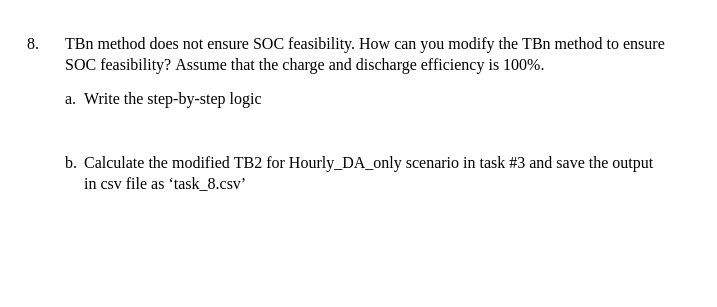